项目名称：用户流失分析

项目描述：产品新手期流失问题较为严重， 需要定位流失点，了解用户具体流失原因，从而针对性的进行调整和优化，同时需要一套行之有效的流失预警模型，及时对高价值用户进行流失召回，避免付费用户流失给产品带来的损失

In [4]:
import numpy as np
import pandas as pd

import os
os.chdir('C:/Users/Administrator/Desktop/个人作品/辰光项目/流失分析/数据源/')

import bokeh
from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Kaiti'] 

pd.set_option('display.float_format',lambda x : '%.2f' % x)

Loading BokehJS ...

In [2]:
df_mission = pd.read_csv('主线任务记录.csv')
df_message = pd.read_excel('流失用户信息.xlsx')
df_message = df_message[df_message['服务器ID'] != 2001]

1、首先看看主线任务的完成情况，查看是否存在卡点，卡点在什么地方，并进行可视化

Text(0, 0.5, '主线任务id')

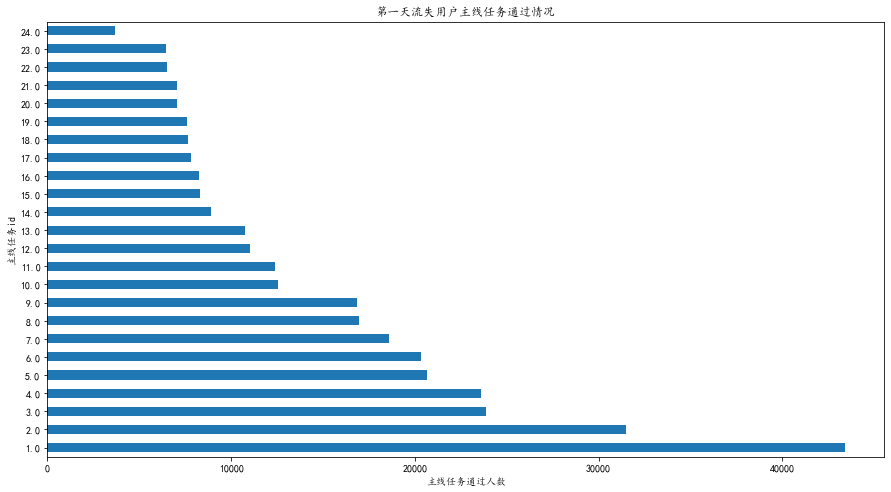

In [6]:
df_lost_list = df_message['角色ID']
df_lost_list = pd.DataFrame(df_lost_list)
lost_mission = pd.merge(df_mission,df_lost_list,left_on = '玩家id',right_on = '角色ID',how = 'right')[['角色ID','玩家id','任务id','主线任务']]

plt.figure(figsize=(15,8))
lost_mission['任务id'].value_counts().head(24).plot.barh()

plt.title('第一天流失用户主线任务通过情况')
plt.xlabel('主线任务通过人数')
plt.ylabel('主线任务id')

玩家在第2,3,10,24个主线任务处通关人数急剧下滑，产生了明显的流失节点

1.00     43391
2.00     31513
3.00     23862
4.00     23606
5.00     20635
         ...  
73.00        1
79.00        1
77.00        1
82.00        1
80.00        1
Name: 任务id, Length: 82, dtype: int64

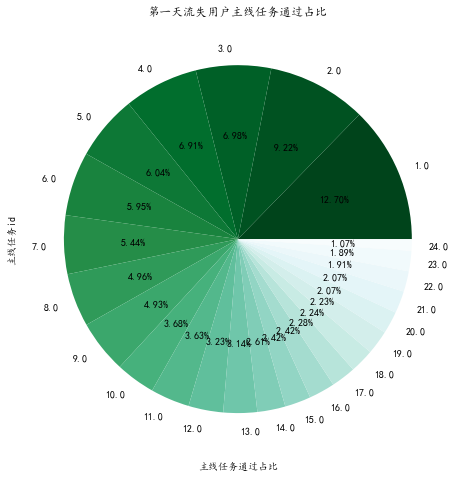

In [7]:
plt.figure(figsize=(15,8))
lost_mission['任务id'].value_counts().head(24).plot.pie(autopct='%.2f%%',colormap ='BuGn_r')
plt.title('第一天流失用户主线任务通过占比')
plt.xlabel('主线任务通过占比')
plt.ylabel('主线任务id')

lost_mission['任务id'].value_counts()

仅33%的玩家通过了第十以后的主线任务，流失发生点偏前期，可能是由于部分主线任务引导不明确（例:使用**物品，跳转背包后并未激活道具或跳转购买页面，需要在背包中自行寻找）

2、前期送/投放给玩家的道具是否迎合了玩家的需求，玩家对于前期投放奖励是否满意

In [8]:
df_pay = pd.read_csv('普通商城购买记录.csv')

In [9]:
#拉取一个长周期的数据，观察随着开服天数的增长，不同时期道具偏好的变化情况
import datetime

df_pay_linyu = df_pay[df_pay['货币类型'] == 2]
df_pay_linyu['date'] = df_pay_linyu['时间'].str.split(' ').str[0]

df_pay_linyu = df_pay_linyu[['date','玩家id','商品id','货币类型','购买数量']]


pivot = pd.pivot_table(df_pay_linyu,values = ['购买数量'],
                     index = ['date','商品id'],aggfunc = np.sum)

np.set_printoptions(suppress = True)

lst = df_pay_linyu['date'].unique().tolist()

c = pd.DataFrame()
for i in lst:
    c = pd.concat([c,pivot.loc[i].sort_values(['购买数量'],ascending = False)],axis = 1)
    
    ret = list(c.columns)
    columns_number = len(c.columns)
    ret[columns_number - 1] =  i
    c.columns = ret

c = c.fillna(0)

c_sort_T = c.T.sort_index()

In [10]:
persons = []
cov = []
std_x = []
std_y = []
for i in c_sort_T.columns:
    x = list(range(1,29))
    y = c_sort_T[i][:28]
    x_std = np.std(x)
    y_std = np.std(y)
    person = np.cov(x,y)[1][0] / (x_std * y_std)
    persons.append(person)
    cov.append(np.cov(x,y)[1][0])
    std_x.append(x_std)
    std_y.append(y_std)

c['persons'] = persons
c['cov'] = cov
c['std_x'] = std_x
c['std_y'] = std_y
result = c.sort_values('persons',ascending = True)[['1day','2day','3day','4day','5day','6day','7day','8day','9day','10day'
                                                     '11day','12day','13day','14day','15day','16day','17day','18day','19day',
                                                      '20day','21day','22day','23day','24day','25day','26day','27day','28day','.....','persons']]
result

,id,1day,2day,3day,4day,5day,6day,7day,8day,9day,...,21day,22day,23day,24day,25day,26day,27day,28day,.....,persons
0,50300004,981,1859,3107,2732,2546,2126,1688,1403,1199,...,481,377,349,406,386,403,262,311,.....,-0.86
1,50300002,1585,2862,4784,4284,3843,2920,2578,1771,1743,...,555,598,431,608,487,473,320,333,.....,-0.85
2,90000008,92,48,66,74,62,43,29,17,21,...,5,3,8,10,7,11,1,5,.....,-0.85
3,90000002,196,186,302,408,385,252,194,113,102,...,23,21,23,28,32,15,8,18,.....,-0.84
4,50300005,618,1308,2120,2365,2220,1871,1739,1305,1170,...,428,341,411,362,369,285,260,260,.....,-0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,90000072,0,0,0,0,0,0,0,0,0,...,15,12,16,31,15,18,13,9,.....,0.79
143,90000081,0,0,0,0,0,0,0,0,0,...,10,15,11,24,18,8,14,7,.....,0.79
144,90000080,0,0,0,0,0,0,0,0,0,...,7,11,4,5,7,8,6,8,.....,0.80
145,90000050,0,0,0,0,0,0,0,0,0,...,10,8,8,15,6,9,8,8,.....,0.81


根据相关系数以及道具量级，汇总出上表所呈现的数据，可以清晰的发现存在不少由于剧情引导以及游戏内设计而导致的开服购买数量多，开服后购买数量锐减的道具

根据流失玩家的付费偏好，对比累计登陆奖励，可以明显发现奖励并没有很好的迎合玩家的需求

3、发现流失卡点以及流失玩家付费偏好后，我们还需要一个流失预警模型提前对有流失倾向的用户进行干预

首先对登录特征进行处理，将登录行为量化为未登录天数以及累计登录天数

In [11]:
#登录

login = pd.read_csv('log_train_features.csv')
end = pd.Timestamp('2020-06-28')


def filiter(df,end,name_of_time,name_of_result1,name_of_result2):
    df[name_of_time] = pd.to_datetime(df[name_of_time])
    players = df['角色ID'].unique()
    
    lst1 = []
    lst2 = []
    for i in players:
        player_log = df[df['角色ID'] == i]
        date = player_log[name_of_time]
        if player_log.empty:
            Days_not_login_to_today =  len(df[name_of_time].unique())
            count_unique_date = len(player_log)
        else:
            last_date = date.max()
            Days_not_login_to_today =  (end - last_date).days
            count_unique_date = len(date.unique())
        
        
        lst1.append(Days_not_login_to_today)
        lst2.append(count_unique_date)
        
    result = pd.DataFrame({'角色ID':players,name_of_result1:lst1,name_of_result2:lst2})
    return result
        
log_data = filiter(login,end,'日期','未登录至今天数','累计登录天数')

然后对付费行为进行处理，量化为未付费天数与累计付费天数

In [12]:
#付费

money = pd.read_csv('money_train_features.csv')
money['订单日期'] = pd.to_datetime(money['订单时间'].str.split(' ').str[0])

#累计充值金额&充值次数
a1 = money[['角色ID','充值金额']].groupby('角色ID').sum()[['充值金额']]
a2 = money[['角色ID','充值金额']].groupby('角色ID').count()[['充值金额']]
a = pd.merge(a1,a2,left_index = True,right_index = True)
a = a.rename(columns = {'充值金额_x':'累计充值金额','充值金额_y':'累计充值次数'})

b = filiter(money,end,'订单日期','未充值至今天数','累计充值天数')

#付费维度指标
pay_data = pd.merge(a.reset_index(),b,on = '角色ID')

合并两个数据

In [14]:
#train

train = pd.merge(log_data,pay_data,on = '角色ID',how = 'left')
train['未充值至今天数'] = train['未充值至今天数'].fillna(14)
train = train.fillna(0)

#确定target:如果流失就是1，不流失就是0
log_target = pd.read_csv('log_train_target.csv')

log_target = pd.DataFrame(log_target['角色ID'].unique())
log_target = log_target.rename(columns = {0:'is_lost'})

train = pd.merge(train,log_target,left_on = '角色ID',right_on = 'is_lost',how = 'left')
train = train.fillna(1)

train['is_lost'][(train['is_lost'] != 1)] = 0

columns = ['未登录至今天数', '累计登录天数', '累计充值金额', '累计充值次数', '未充值至今天数', '累计充值天数']
train_columns = train.columns.drop(['角色ID','is_lost'])

<ipython-input-14-a77383e6453e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_lost'][(train['is_lost'] != 1)] = 0


先使用逻辑回归训练模型，查看哪些特征对于结果的影响更大

In [16]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train[train_columns],train['is_lost'])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0],
                               index=train[train_columns].columns)

feature_importance.abs().sort_values(ascending = False)

未登录至今天数   0.28
累计登录天数    0.24
累计充值天数    0.10
未充值至今天数   0.09
累计充值次数    0.03
累计充值金额    0.00
dtype: float64

可以发现，登录行为相比充值行为的影响更大一些

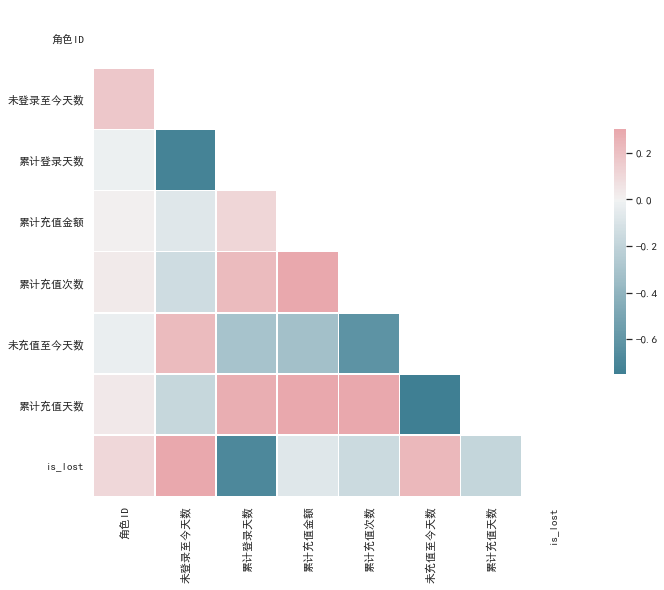

In [17]:
#消除共线性的影响

import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df):
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
    sns.set(font='SimHei',style="white")
    
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
plot_correlation_heatmap(train)

采用三种模型（逻辑回归，knn以及随机森林）分别进行网格搜索，并得出精确度

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



def select_model(df,cols):
    dic = {}
    all_X = df[cols]
    all_y = df['is_lost']
    
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]
    
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        grid = GridSearchCV(model['estimator'],param_grid = model['hyperparameters'],cv = 10)
        grid.fit(all_X,all_y)
        
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [19]:
result = select_model(train,train_columns)

LogisticRegression
------------------
Best Score: 0.854309554850653
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.8589296774215625
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8616202149610421
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 9}



可以发现随机森林模型的精确度最高，后续将以此进行建模分析

模型检验：读取一个测试数据对模型进行校验

In [22]:
#用一个数据去验证这个精度

#测试集登录
end = pd.Timestamp('2020-05-31')
log_test_features = pd.read_csv('log_test_features.csv')
login_data_t = filiter(log_test_features,end,'日期','未登录至今天数','累计登录天数')


#测试集付费
money = pd.read_csv('money_test_features.csv')
money['订单日期'] = pd.to_datetime(money['订单时间'].str.split(' ').str[0])

#累计充值金额&充值次数
a1 = money[['角色ID','充值金额']].groupby('角色ID').sum()[['充值金额']]
a2 = money[['角色ID','充值金额']].groupby('角色ID').count()[['充值金额']]
a = pd.merge(a1,a2,left_index = True,right_index = True)
a = a.rename(columns = {'充值金额_x':'累计充值金额','充值金额_y':'累计充值次数'})

b = filiter(money,end,'订单日期','未充值至今天数','累计充值天数')

#付费维度指标
pay_data_t = pd.merge(a.reset_index(),b,on = '角色ID')


#test
test = pd.merge(login_data_t,pay_data_t,on = '角色ID',how = 'left')
test['未充值至今天数'] = test['未充值至今天数'].fillna(14)
test = test.fillna(0)


#确定target:如果流失就是1，不流失就是0
test_target = pd.read_csv('log_test_target.csv')

test_target = pd.DataFrame(test_target['角色ID'].unique())
test_target = test_target.rename(columns = {0:'is_lost'})

test = pd.merge(test,test_target,left_on = '角色ID',right_on = 'is_lost',how = 'left')
test = test.fillna(1)

test['is_lost'][(test['is_lost'] != 1)] = 0

# test = pre_process(test)
test_columns = test.columns.drop(['角色ID','is_lost'])

<ipython-input-22-82ea09da9ce6>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['is_lost'][(test['is_lost'] != 1)] = 0


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

best_rf_model = result[2]["best_model"]
predictions = best_rf_model.predict(test[test_columns])
print(roc_auc_score(test['is_lost'],predictions))

0.8141596969981737


模型的精确度为81%

In [24]:
result[2]

{'name': 'RandomForestClassifier',
 'estimator': RandomForestClassifier(random_state=1),
 'hyperparameters': {'n_estimators': [4, 6, 9],
  'criterion': ['entropy', 'gini'],
  'max_depth': [2, 5, 10],
  'max_features': ['log2', 'sqrt'],
  'min_samples_leaf': [1, 5, 8],
  'min_samples_split': [2, 3, 5]},
 'best_params': {'criterion': 'gini',
  'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 9},
 'best_score': 0.8616202149610421,
 'best_model': RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=8,
                        n_estimators=9, random_state=1)}

4、最终效果：在调整了前期卡点以及投放内容，并依据流失预警模型积极干预之后，用户在前三个关卡的留存平均提升了4.6%，前十个关卡的平均留存提升了2%，用户前期留存得到了明显改善

In [25]:
def choice(a,b):
    if a  == 0:
        return b
    else:
        return a

In [26]:
def category_task_completion(data,new_player):
    #完成率
    completion = pd.pivot_table(data,index = '任务id',columns = '行为',values = '角色ID',aggfunc = len)
    completion['完成率'] = completion['结束(17002)'] / completion['开始(17001)']
    completion = completion.reset_index()
    
    completion['id'] = completion['任务id'].str.split('(').str[1].str.split(')').str[0]
    completion['任务名称'] = completion['任务id'].str.split('(').str[0]
    
    #留存率
    completion['新增人数'] = new_player
    completion['留存率'] = completion['结束(17002)'] / completion['新增人数']
    
    return completion.sort_values('id')[['任务名称','完成率','留存率']]

In [27]:
task = pd.read_csv('关卡进度记录.csv')
task_m = pd.merge(task,log[['角色ID','创建日期']].drop_duplicates(),left_on = '玩家id',right_on = '角色ID',how = 'left')
task_d = task_m.fillna(0)

task_d['记录时间'] = task_d.apply(lambda row : choice(row['进入时间'],row['结束时间']),axis = 1) 
task_d['记录日期'] = pd.to_datetime(task_d['记录时间'].str.split(' ').str[0])

In [28]:
before_task = task_d[(task_d['记录日期'] >= '2020-06-18') & (task_d['记录日期'] <= '2020-06-30') & (task_d['创建日期'] >= '2020-06-18') & (task_d['创建日期'] <= '2020-06-30')]
after_task = task_d[(task_d['记录日期'] >= '2020-7-1') & (task_d['创建日期'] >= '2020-7-1')]

In [30]:
before_completion = category_task_completion(before_task,2*0*2*)  #为了避嫌，将具体数据隐去
after_completion = category_task_completion(after_task,*9*3*6)

completion = pd.merge(before_completion,after_completion,on = '任务名称',how = 'left',suffixes= ['_更新前','_更新后'])
completion['对比_完成率'] = completion['完成率_更新后'] - completion['完成率_更新前']
completion['对比_留存率'] = completion['留存率_更新后'] - completion['留存率_更新前']
completion[['完成率_更新前','完成率_更新后','对比_完成率','留存率_更新前','留存率_更新后','对比_留存率']]
completion

,关卡ID,完成率_更新前,完成率_更新后,对比_完成率,留存率_更新前,留存率_更新后,对比_留存率
0,0,0.88,0.88,-0.00,0.69,0.74,0.05
1,1,0.96,0.95,-0.00,0.64,0.69,0.05
2,2,0.96,0.96,-0.00,0.61,0.65,0.04
3,3,0.93,0.92,-0.01,0.47,0.49,0.03
4,4,0.96,0.96,0.00,0.39,0.41,0.02
5,5,0.98,0.98,0.00,0.34,0.35,0.01
6,6,0.97,0.98,0.00,0.28,0.28,0.00
7,7,0.97,0.98,0.00,0.28,0.30,0.01
8,8,0.99,0.99,0.00,0.24,0.24,0.00
9,9,0.99,0.99,0.00,0.23,0.23,0.00
